In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import classes.nb_general as NB_G 
import classes.visual_tools as VS
import scipy.linalg as la

In [11]:
class GraphLibrary:
    
    def __init__(self, direc=''):
        self.direc = direc

    def save_graph(self,G,graph_descrip):
        """ Given a graph and description, save it in our home directory. """
        
        with open('{}/graph_descriptions.txt'.format(self.direc), 'r+') as log_:
            i = len(log_.readlines())
            # Record our graph & Description
            log_.write("Graph {}: {}\n".format(i,graph_descrip))
            log_.close()

        nx.write_gml(G,r"{}/graph_{}.gml".format(self.direc,i),str)
        
    def load_graph(self, k):
        """ Given an index, load the specific graph. """
        
        with open('{}/graph_descriptions.txt'.format(self.direc), 'r+') as log_:    
            
            descrip_ = log_.readlines()[k]
            
        G = nx.read_gml(r"{}/graph_{}.gml".format(self.direc,k))
        
        return G, descrip_ 
    
def run(G, a_=.95):
    A = nx.adjacency_matrix(G).todense()
    C, B = NB_G.to_edge_space(G,graph=False, B = True)
    S, T = NB_G.create_s_t(G)
    D_hat = np.diag(np.array(B.sum(axis=1)).reshape((B.shape[1],)))
    D = np.array(A.sum(axis=1)).reshape(A.shape[1],)

    # Get page rank of the edge space
    pr_e = np.array(list(nx.pagerank(nx.Graph(B,alpha=a_)).values()))
    
    # 'Spring Paper Eqn' 
    eqn = lambda alpha: la.solve(np.eye(B.shape[0])-alpha*B.T@la.solve(D_hat,np.eye(D_hat.shape[0])),(1-alpha)/A.shape[0]*T.T@(la.solve(T@T.T,np.eye(T.shape[0])))@np.ones(T.T.shape[1]))

    # Get page rank of the vertex space
    pr_v = np.array(list(nx.pagerank(nx.Graph(G,alpha=a_)).values()))
    pr_v_w = pr_v/D
    

    # Get projection of edge space to vertex space of appropriate page rank vectors
    pr_ = T@pr_e
    pr_w = pr_/D
    pr_2 = T@eqn(a_)
    pr_2_w = pr_2/D

    # Show Graphs
    plt.figure(figsize=(15,5))
    #plt.suptitle('Comparison of Graphs\n', fontsize=25)
    plt.subplot(121)
    plt.title("Normal Graph - $B$", fontsize=15)
    nx.draw(G,with_labels=True)
    plt.subplot(122)
    plt.title("Edge Space Graph - $\mathfrak{B}$", fontsize=15)
    nx.draw(nx.from_numpy_array(B), with_labels=True)
    plt.show()

    # Show Page Rank Values
    DOMAIN = np.arange(0, len(pr_v), 1)
    plt.figure(figsize=(15,5))
    plt.title("Page Rank Values", fontsize=25)
    plt.plot(DOMAIN, pr_v, 'o--', label='Original')
    plt.plot(DOMAIN, pr_,  'o--', label='Non-backtrack')
    #plt.plot(DOMAIN, pr_2,  'o--', label='Non-backtrack Springer')
    plt.legend(loc='best', fontsize=20)
    plt.xlabel("Vertex", fontsize=20)
    plt.ylabel("Node Value", fontsize=2)
    plt.show()
    
    return pr_v, pr_

# Test Graph

Graph 2: Clear cut on page rank vector.



/Users/tylerjones/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


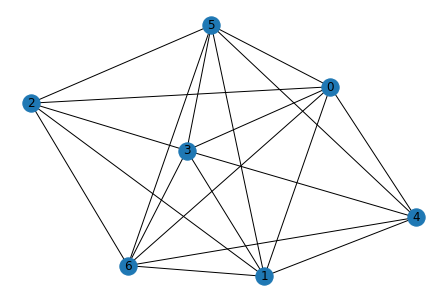

In [12]:
GAO = GraphLibrary('TEST_GRAPHS/GRAPHS')
G, descrip = GAO.load_graph(k=2)

print(descrip)
nx.draw(G,with_labels=True)
plt.show()

In [13]:
print(nx.to_numpy_matrix(G))

[[0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 0.]]


/Users/tylerjones/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


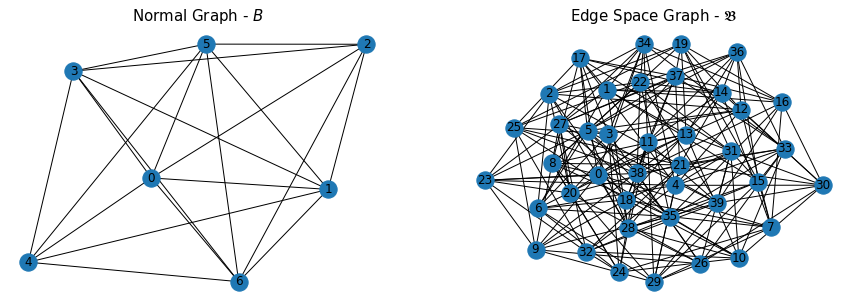

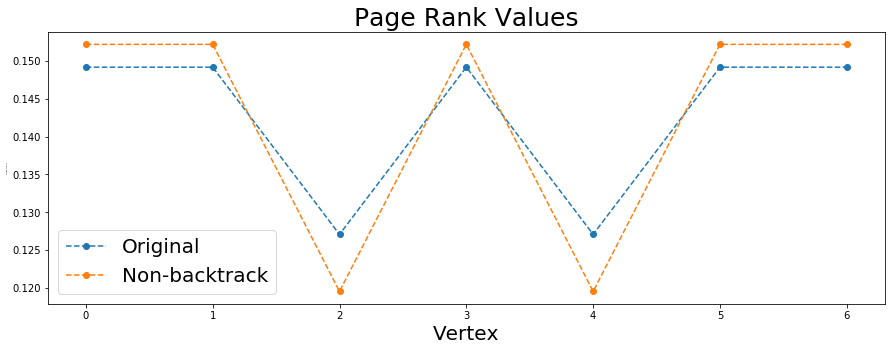

In [6]:
run(G)

In [7]:
nx.pagerank(G)

{'0': 0.14916519482193671,
 '1': 0.14916519482193671,
 '2': 0.12708701294515817,
 '3': 0.14916519482193671,
 '4': 0.12708701294515817,
 '5': 0.14916519482193671,
 '6': 0.14916519482193671}

# Step 1 - Proof of Page Rank for Complete Graphs

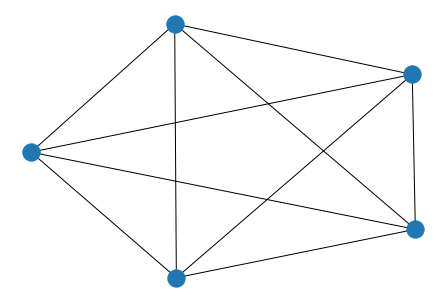

In [55]:
n = 5
eps = .9
G = nx.complete_graph(n)
nx.draw(G)
A = nx.to_numpy_matrix(G)

In [56]:
print(la.inv((np.eye(n)-(eps/(n-1))*A)))
phi = eps/(n-1)

[[2.65306122 1.83673469 1.83673469 1.83673469 1.83673469]
 [1.83673469 2.65306122 1.83673469 1.83673469 1.83673469]
 [1.83673469 1.83673469 2.65306122 1.83673469 1.83673469]
 [1.83673469 1.83673469 1.83673469 2.65306122 1.83673469]
 [1.83673469 1.83673469 1.83673469 1.83673469 2.65306122]]


In [57]:
(3*phi-1)/((4*phi-1)*(phi+1))

2.6530612244897958

In [71]:
def build_inv(k, phi):
    
    assert k > 2
    
    d = ((k-2)*phi-1)/(((k-1)*phi-1)*(phi+1))
    o = -phi/(((k-1)*phi-1)*(phi+1))
    
    A = np.ones((k,k))*o
    for i in range(k):
        A[i,i] = d
    
    return A
    

In [87]:
for k in range(3,200):
    A = nx.to_numpy_matrix(nx.complete_graph(k))
    phi = eps/(k-1)
    A = (np.eye(k)-phi*A)
    A_inv = build_inv(k,phi)
    
    print(np.allclose(A@A_inv, np.eye(k)))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Part 2 - Pruning Complete Graph

In [172]:
normal_pr = []
nbr_pr = []

G = nx.complete_graph(7)
print(G.edges)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


/Users/tylerjones/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


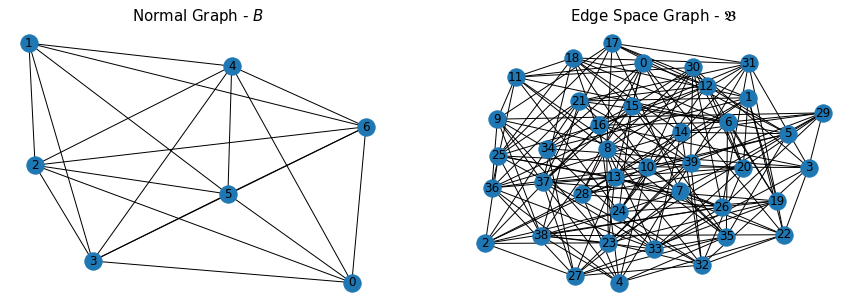

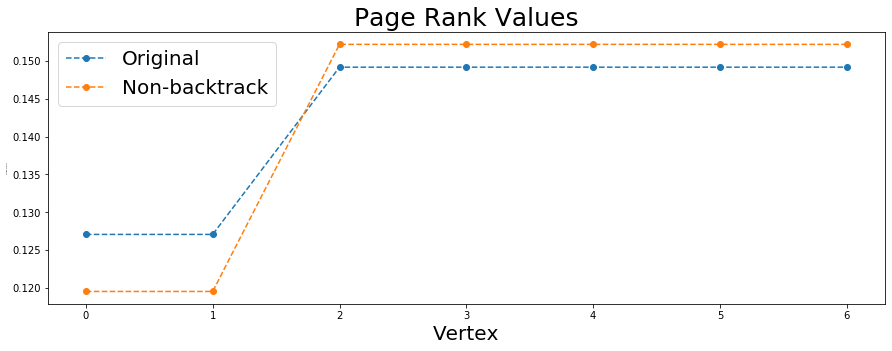

/Users/tylerjones/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


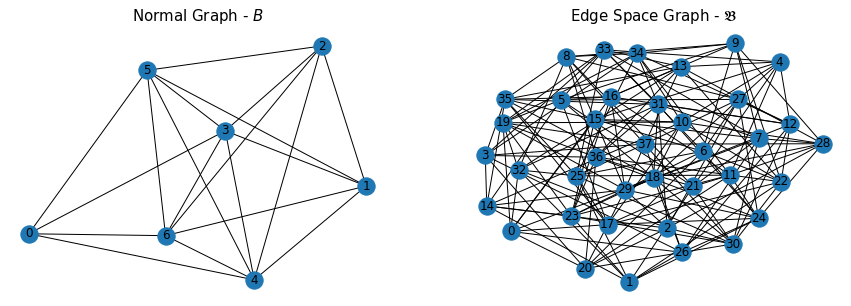

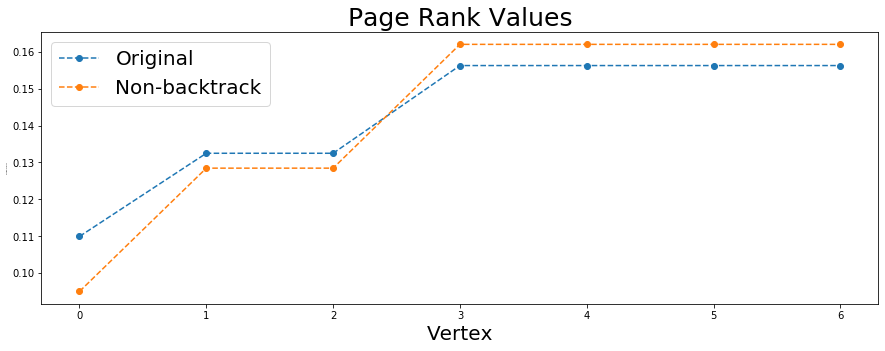

/Users/tylerjones/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


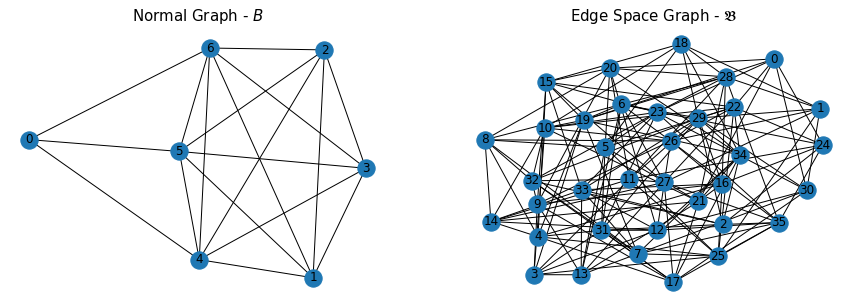

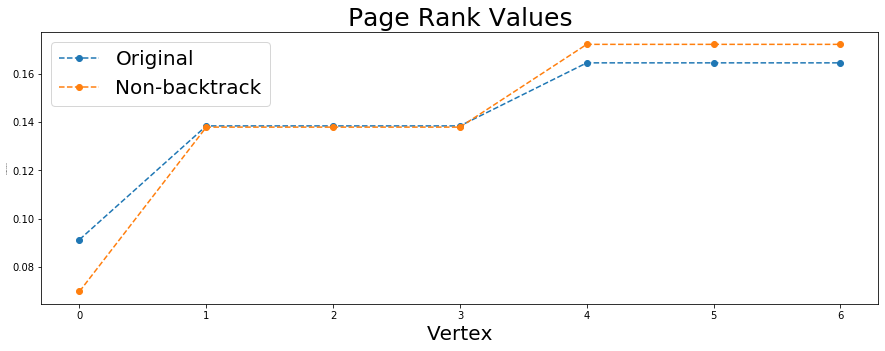

/Users/tylerjones/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


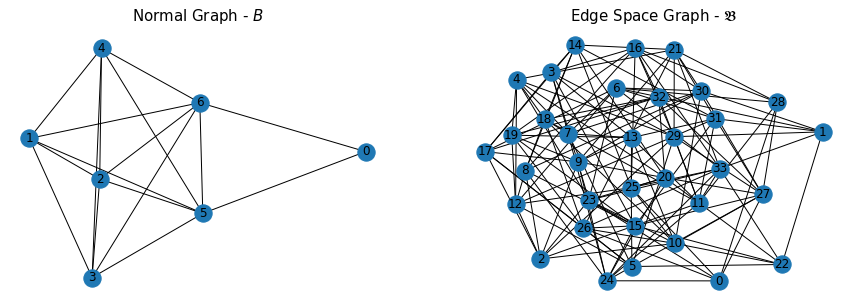

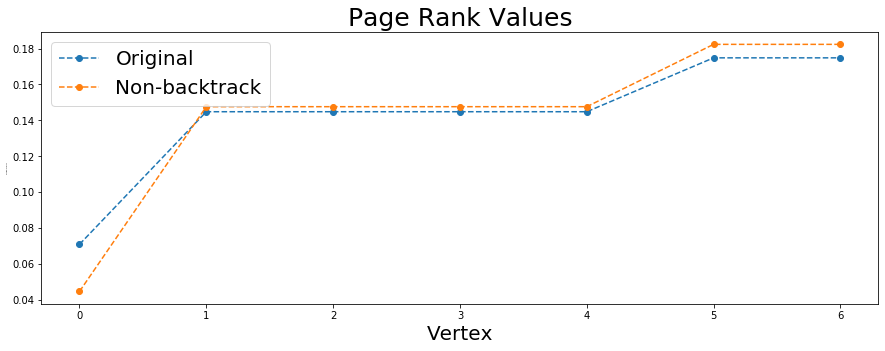

In [173]:
G.remove_edge(0,1)
a, b = run(G)
normal_pr.append(a)
nbr_pr.append(b)

G.remove_edge(0,2)
a, b = run(G)
normal_pr.append(a)
nbr_pr.append(b)

G.remove_edge(0,3)
a, b = run(G)
normal_pr.append(a)
nbr_pr.append(b)

G.remove_edge(0,4)
a, b = run(G)
normal_pr.append(a)
nbr_pr.append(b)

In [176]:
T = np.array(normal_pr)
T

array([[0.12708701, 0.12708701, 0.14916519, 0.14916519, 0.14916519,
        0.14916519, 0.14916519],
       [0.10997454, 0.13249925, 0.13249925, 0.15625674, 0.15625674,
        0.15625674, 0.15625674],
       [0.09133903, 0.13839231, 0.13839231, 0.13839231, 0.16449469,
        0.16449469, 0.16449469],
       [0.07096853, 0.144834  , 0.144834  , 0.144834  , 0.144834  ,
        0.17484772, 0.17484772]])

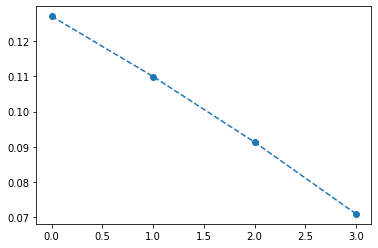

In [177]:
for i in range(1):
    plt.plot(T[:4,i], 'o--')
plt.show()

In [208]:
GAO = GraphLibrary('TEST_GRAPHS/GRAPHS')
G, descrip = GAO.load_graph(k=4)


IndexError: list index out of range

In [215]:
G = nx.complete_graph(100)
a, b = run(G)

KeyboardInterrupt: 

In [210]:
np.var(a)

0.00020622933358042437

In [211]:
np.var(b)

0.0007452207053865751

In [212]:
np.mean(a)

0.0769230769230769

In [214]:
np.mean(b)

0.07692307692307693

In [15]:
la.inv(nx.to_numpy_array(G))

LinAlgError: singular matrix

In [127]:
N = 4
G = nx.complete_graph(N)

In [128]:
nx.to_numpy_array(G)
G.remove_edge(0,1)
#G.remove_edge(1,2)
print(nx.to_numpy_array(G))

[[0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [129]:
P = nx.to_numpy_array(G)/nx.to_numpy_array(G).sum(axis=0)

In [130]:
eps=.9
A_ = eps*P+((1-eps)/4)*np.ones((N,N))

In [131]:
A_
#la.inv((np.eye(4)-nx.to_numpy_array(G))

array([[0.025, 0.025, 0.325, 0.325],
       [0.025, 0.025, 0.325, 0.325],
       [0.475, 0.475, 0.025, 0.325],
       [0.475, 0.475, 0.325, 0.025]])

In [132]:
#la.det(A_)
INV = la.inv((np.eye(N)-eps*P))
print(np.unique(INV))

[1.6875     1.875      2.6875     2.74038462 2.8125     2.8125
 3.50961538 3.50961538]


In [133]:
INV

array([[2.6875    , 1.6875    , 1.875     , 1.875     ],
       [1.6875    , 2.6875    , 1.875     , 1.875     ],
       [2.8125    , 2.8125    , 3.50961538, 2.74038462],
       [2.8125    , 2.8125    , 2.74038462, 3.50961538]])